# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min, max, sum, round
from pyspark.sql.types import IntegerType, DateType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
# 加载数据
filename = 'mini_sparkify_event_data.json'
df = spark.read.json(filename)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

从上面加载的数据可以看出DataFrame里面包含哪些columns。
* artist (string)
* auth (string)
* firstName (string)
* gender (string)
* itemInSession (bigint)
* lastName (string)
* length (double)
* level (string)
* location (string)
* method (string)
* page (string)
* registration (bigint)
* sessionId (bigint)
* song (string)
* status (bigint)
* ts (bigint)
* userAgen (string)
* userId (string)

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [6]:
# 查看数据集的大小
df.count(),len(df.columns)

(286500, 18)

数据集中的用户信息

In [7]:
# 获取数据集中用户的数量
df.select("userId").distinct().count()

226

从这里可以看出一共有226个用户。

In [8]:
# 查看userId中是否有缺失值
df.where(df.userId.isNull()).count()

0

In [9]:
df.select(['userId']).drop_duplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



发现userId里面存在空值。

In [10]:
df.where(df['userId']=="").count()

8346

userId变量存在8364个空值。

In [11]:
df.where(df['userId']=="").groupby('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



从上面两个cell可以看出，当数据的userId缺失的时候，auth属于登出(Logged Out)或者游客状态(Guest)。

用户信息除了firstName, lastName, userId这些静态的变量，还有有一个变量是会变化的，那就是level变量，它会根据用户的订阅状态变化。

In [12]:
df.groupby('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [13]:
level = df.where(df['userId']!="") \
    .groupby(['userId']) \
    .agg(sum(when(col('level')=='free', 1).otherwise(0)).alias('free level'),
        sum(when(col('level')=='paied',1).otherwise(0)).alias('paid level'))

level.show(5)

+------+----------+----------+
|userId|free level|paid level|
+------+----------+----------+
|100010|       381|         0|
|200002|       120|         0|
|   125|        11|         0|
|    51|         0|         0|
|   124|         0|         0|
+------+----------+----------+
only showing top 5 rows



In [14]:
df.where(df.page.isNull()).count()

0

page没有空值。

In [15]:
# page的分布
df.groupby('page').count().sort('count', ascending=False).show(100) # 100是为了能够显示所有的

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



In [16]:
df.where(df['auth']=='Cancelled').select(['userId', 'ts', 'sessionId', 'auth', 'page']).show(5)

+------+-------------+---------+---------+--------------------+
|userId|           ts|sessionId|     auth|                page|
+------+-------------+---------+---------+--------------------+
|    18|1538943990000|      514|Cancelled|Cancellation Conf...|
|    32|1539033046000|      540|Cancelled|Cancellation Conf...|
|   125|1539318918000|      174|Cancelled|Cancellation Conf...|
|   105|1539375441000|      508|Cancelled|Cancellation Conf...|
|    17|1539465584000|      797|Cancelled|Cancellation Conf...|
+------+-------------+---------+---------+--------------------+
only showing top 5 rows



In [17]:
df.where(col("auth")=="Cancelled").select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|Cancellation Conf...|
+--------------------+



从上面的cell可以看出auth为"Cancelled"的时候，page变量都是"Cancellation Confirmation"。

In [18]:
#df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()
df.select(sum(col("sessionId").isNull().cast("int"))).show()

+-------------------------------------+
|sum(CAST((sessionId IS NULL) AS INT))|
+-------------------------------------+
|                                    0|
+-------------------------------------+



从上面的cell可以看出变量sessionId没有缺失值。

In [19]:
# 查看session在系统中的存在时间的分布
session_last_time = df.where(df['userId']!="") \
    .groupby(['userId', 'sessionId']).agg(max('ts').alias('ts max'),
                                        min('ts').alias('ts min'),
                                        ((max('ts')-min('ts'))/1000).alias('session length'))\
    .sort('session length', ascending=False).show(5)

+------+---------+-------------+-------------+--------------+
|userId|sessionId|       ts max|       ts min|session length|
+------+---------+-------------+-------------+--------------+
|    91|     1840|1542852334000|1542585029000|      267305.0|
|   115|      316|1538924417000|1538701498000|      222919.0|
|   101|      635|1539263366000|1539065365000|      198001.0|
|   120|      731|1539793336000|1539630700000|      162636.0|
|    61|      529|1539247693000|1539096212000|      151481.0|
+------+---------+-------------+-------------+--------------+
only showing top 5 rows



In [20]:
# 查看method和page的关系
df.groupby(['method', 'page']).count().sort('method').show(22)

+------+--------------------+------+
|method|                page| count|
+------+--------------------+------+
|   GET|               Error|   258|
|   GET|                Help|  1726|
|   GET|            Settings|  1514|
|   GET|                Home| 14457|
|   GET|Cancellation Conf...|    52|
|   GET|            Register|    18|
|   GET|           Downgrade|  2055|
|   GET|         Roll Advert|  3933|
|   GET|               About|   924|
|   GET|             Upgrade|   499|
|   PUT|              Cancel|    52|
|   PUT|              Logout|  3226|
|   PUT|     Add to Playlist|  6526|
|   PUT|          Add Friend|  4277|
|   PUT| Submit Registration|     5|
|   PUT|      Submit Upgrade|   159|
|   PUT|           Thumbs Up| 12551|
|   PUT|    Submit Downgrade|    63|
|   PUT|               Login|  3241|
|   PUT|            NextSong|228108|
|   PUT|         Thumbs Down|  2546|
|   PUT|       Save Settings|   310|
+------+--------------------+------+



In [21]:
# status和page的分布
df.groupby(['status','page']).count().sort('status').show(22)

+------+--------------------+------+
|status|                page| count|
+------+--------------------+------+
|   200|             Upgrade|   499|
|   200|     Add to Playlist|  6526|
|   200|Cancellation Conf...|    52|
|   200|            NextSong|228108|
|   200|         Roll Advert|  3933|
|   200|            Register|    18|
|   200|                Help|  1726|
|   200|            Settings|  1514|
|   200|               About|   924|
|   200|           Downgrade|  2055|
|   200|                Home| 14457|
|   307|           Thumbs Up| 12551|
|   307|              Logout|  3226|
|   307|         Thumbs Down|  2546|
|   307|               Login|  3241|
|   307|    Submit Downgrade|    63|
|   307|       Save Settings|   310|
|   307|              Cancel|    52|
|   307|      Submit Upgrade|   159|
|   307|          Add Friend|  4277|
|   307| Submit Registration|     5|
|   404|               Error|   258|
+------+--------------------+------+



### 可视化

In [22]:
gender_dist = df.select(['userId', 'gender'])\
    .where(df.userId != "") \
    .dropDuplicates(['userId']).groupby('gender').count().toPandas()
gender_dist = gender_dist.set_index('gender')

In [23]:
gender_dist.head()

,count
gender,
F,104
M,121


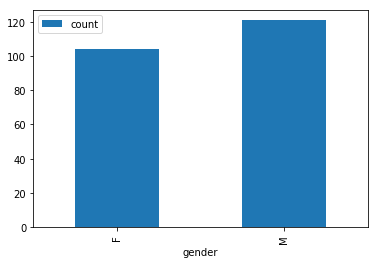

In [24]:
gender_dist.plot.bar()

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

首先对时间进行转换，以便于观察。

In [25]:
# 对时间进行转换
df = df.withColumn('tsDate', (df['ts']/1000).cast(TimestampType()))
df = df.withColumn('registrationDate', (df['registration']/1000).cast(TimestampType()))

In [26]:
df.select(['ts', 'tsDate', 'registration','registrationDate']).sort('ts').show(5)

+-------------+-------------------+-------------+-------------------+
|           ts|             tsDate| registration|   registrationDate|
+-------------+-------------------+-------------+-------------------+
|1538352117000|2018-10-01 08:01:57|1538173362000|2018-09-29 06:22:42|
|1538352180000|2018-10-01 08:03:00|1538331630000|2018-10-01 02:20:30|
|1538352394000|2018-10-01 08:06:34|1538173362000|2018-09-29 06:22:42|
|1538352416000|2018-10-01 08:06:56|1538331630000|2018-10-01 02:20:30|
|1538352676000|2018-10-01 08:11:16|1538173362000|2018-09-29 06:22:42|
+-------------+-------------------+-------------+-------------------+
only showing top 5 rows



In [27]:
df.select(['ts', 'tsDate', 'registration','registrationDate']).sort('ts', ascending=False).show(5)

+-------------+-------------------+-------------+-------------------+
|           ts|             tsDate| registration|   registrationDate|
+-------------+-------------------+-------------+-------------------+
|1543799476000|2018-12-03 09:11:16|1529934689000|2018-06-25 21:51:29|
|1543622579000|2018-12-01 08:02:59|1533670697000|2018-08-08 03:38:17|
|1543622432000|2018-12-01 08:00:32|1540940608000|2018-10-31 07:03:28|
|1543622411000|2018-12-01 08:00:11|1538336771000|2018-10-01 03:46:11|
|1543622398000|2018-12-01 07:59:58|1538336771000|2018-10-01 03:46:11|
+-------------+-------------------+-------------+-------------------+
only showing top 5 rows



In [28]:
df.select(['ts','tsDate','registration','registrationDate']).sort('ts').show(5)

+-------------+-------------------+-------------+-------------------+
|           ts|             tsDate| registration|   registrationDate|
+-------------+-------------------+-------------+-------------------+
|1538352117000|2018-10-01 08:01:57|1538173362000|2018-09-29 06:22:42|
|1538352180000|2018-10-01 08:03:00|1538331630000|2018-10-01 02:20:30|
|1538352394000|2018-10-01 08:06:34|1538173362000|2018-09-29 06:22:42|
|1538352416000|2018-10-01 08:06:56|1538331630000|2018-10-01 02:20:30|
|1538352676000|2018-10-01 08:11:16|1538173362000|2018-09-29 06:22:42|
+-------------+-------------------+-------------+-------------------+
only showing top 5 rows



In [29]:
# 下次登陆的时候可能还是一个sessionId，记录这个sessionId上一次的ts和session的长度

windowsession = Window.partitionBy(['userId','sessionId']).orderBy('ts')

df = df.withColumn("previousts", lag(df.ts).over(windowsession))
#temp.select(['userId', 'sessionId', 'ts', 'tsDate',"previousts"]).show(20)
df = df.withColumn("diff",(df.ts - df.previousts)/1000)
df.select(['userId', 'sessionId', 'ts', 'tsDate',"previousts", "diff"]).show(20)

+------+---------+-------------+-------------------+-------------+---------+
|userId|sessionId|           ts|             tsDate|   previousts|     diff|
+------+---------+-------------+-------------------+-------------+---------+
|      |      164|1539944514000|2018-10-19 18:21:54|         null|     null|
|      |      164|1541186397000|2018-11-03 03:19:57|1539944514000|1241883.0|
|      |      164|1541186398000|2018-11-03 03:19:58|1541186397000|      1.0|
|      |      268|1538424263000|2018-10-02 04:04:23|         null|     null|
|      |      268|1540891842000|2018-10-30 17:30:42|1538424263000|2467579.0|
|      |      268|1540891843000|2018-10-30 17:30:43|1540891842000|      1.0|
|      |      268|1540905839000|2018-10-30 21:23:59|1540891843000|  13996.0|
|      |      268|1540905840000|2018-10-30 21:24:00|1540905839000|      1.0|
|      |      268|1540907987000|2018-10-30 21:59:47|1540905840000|   2147.0|
|      |      268|1540908375000|2018-10-30 22:06:15|1540907987000|    388.0|

## 将数据集转换成用户级别的变量
为了对数据集进行转换，首先我们需要设定一个观察的时间，在这个时间的内的数据会被记录。

In [30]:
# 观察开始和结束的时间
# 根据上面的cell，可以选用观测时间为 2018-10-01到2018-12-01
obs_start_default = 1538352000000 # 北京时间 2018-10-01 00:08:00
obs_end_default = 1543622400000 # 北京时间 2018-12-01 00:08:00

In [31]:
df.where(df['registration'] > obs_start_default).select(['userId', 'registrationDate']).dropDuplicates().show()

+------+-------------------+
|userId|   registrationDate|
+------+-------------------+
|   156|2018-11-26 23:49:14|
|   153|2018-11-03 13:42:17|
|   154|2018-11-04 02:00:21|
|   155|2018-11-05 06:27:50|
|   152|2018-10-31 07:03:28|
+------+-------------------+



有些user可能是在obs_start_default之后注册的。

In [32]:
df.select(['userId', 'sessionId', 'auth','page', 'tsDate']).where(df.page=='Submit Registration').show()

+------+---------+-----+-------------------+-------------------+
|userId|sessionId| auth|               page|             tsDate|
+------+---------+-----+-------------------+-------------------+
|      |     1402|Guest|Submit Registration|2018-10-30 14:59:07|
|      |     1506|Guest|Submit Registration|2018-11-02 23:13:19|
|      |      154|Guest|Submit Registration|2018-11-02 23:55:56|
|      |     1719|Guest|Submit Registration|2018-11-09 05:10:33|
|      |     2288|Guest|Submit Registration|2018-11-27 07:12:49|
+------+---------+-----+-------------------+-------------------+



可以看到submit Registration页面一共有五个。这里面的userId可能就有上面对应的。

In [33]:
windowsession = Window.partitionBy('sessionId').orderBy('ts')
# lag返回偏移行的值
df = df.withColumn('lagged_page', lag(df.page).over(windowsession))

In [34]:
df.where(df.lagged_page == "Submit Registration").select(['userId','auth','lagged_page','tsDate','sessionId']).show()

+------+---------+-------------------+-------------------+---------+
|userId|     auth|        lagged_page|             tsDate|sessionId|
+------+---------+-------------------+-------------------+---------+
|   156|Logged In|Submit Registration|2018-11-27 07:14:00|     2288|
|   154|Logged In|Submit Registration|2018-11-02 23:15:35|     1506|
|   152|Logged In|Submit Registration|2018-10-30 14:59:09|     1402|
|   155|Logged In|Submit Registration|2018-11-02 23:56:25|      154|
|   153|Logged In|Submit Registration|2018-11-09 05:11:10|     1719|
+------+---------+-------------------+-------------------+---------+



In [35]:
df.select(['userId','auth','lagged_page','page','tsDate','sessionId']).show()

+------+---------+---------------+---------------+-------------------+---------+
|userId|     auth|    lagged_page|           page|             tsDate|sessionId|
+------+---------+---------------+---------------+-------------------+---------+
|    27|Logged In|           null|           Home|2018-10-01 21:25:48|       26|
|    27|Logged In|           Home|       NextSong|2018-10-01 21:26:18|       26|
|    27|Logged In|       NextSong|    Roll Advert|2018-10-01 21:26:58|       26|
|    27|Logged In|    Roll Advert|       NextSong|2018-10-01 21:29:36|       26|
|    27|Logged In|       NextSong|       NextSong|2018-10-01 21:32:31|       26|
|    27|Logged In|       NextSong|       NextSong|2018-10-01 21:36:44|       26|
|    27|Logged In|       NextSong|    Thumbs Down|2018-10-01 21:36:45|       26|
|    27|Logged In|    Thumbs Down|       NextSong|2018-10-01 21:42:16|       26|
|    27|Logged In|       NextSong|       NextSong|2018-10-01 21:47:46|       26|
|    27|Logged In|       Nex

从上面的cell可以得到userId的上一个页面

In [36]:
windowuser = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# 找出哪些是在obs_start_default之后注册的，并且填上他们正确的开始活动的日期
df = df.withColumn("beforefirstlog", first(col('lagged_page')).over(windowuser))
df = df.withColumn("firstlogtime", first(col('ts')).over(windowuser))
df = df.withColumn("obsstart", when(df.beforefirstlog == "Submit Registration", df.firstlogtime).otherwise(obs_start_default))

In [37]:
df.select(['userId', 'beforefirstlog', 'firstlogtime', 'obsstart', 'registration']).where(df.userId==154).show(10)
# obs_start_default: 1538352000000

+------+-------------------+-------------+-------------+-------------+
|userId|     beforefirstlog| firstlogtime|     obsstart| registration|
+------+-------------------+-------------+-------------+-------------+
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
|   154|Submit Registration|1541171735000|1541171735000|1541268021000|
+------+-------------------+-------------+-------------+-------------+
only s

In [38]:
df.select(['userId', 'beforefirstlog', 'firstlogtime', 'obsstart', 'registration']).show(10)

+------+--------------+-------------+-------------+-------------+
|userId|beforefirstlog| firstlogtime|     obsstart| registration|
+------+--------------+-------------+-------------+-------------+
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
|100010|          null|1539003534000|1538352000000|1538016340000|
+------+--------------+-------------+-------------+-------------+
only showing top 10 rows



154是重新矫正过的，10010是正常的。

In [39]:
# 找到最后一个页面是"Cancellation Confirmation"的用户。
df = df.withColumn("endstate", last(col('page')).over(windowuser))
df = df.withColumn("lastlogtime", last(col('ts')).over(windowuser))
df = df.withColumn("obsend", when(df.endstate == "Cancellation Confirmation", df.lastlogtime).otherwise(obs_end_default))

In [40]:
df.select(['userId', 'endstate', 'lastlogtime', 'obsend']).where(df['endstate']=="Cancellation Confirmation").show()
# obs_end_default = 1543622400000 # UTC 2018-12-01 00:00:00

+------+--------------------+-------------+-------------+
|userId|            endstate|  lastlogtime|       obsend|
+------+--------------------+-------------+-------------+
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|   125|Cancellation Conf...|1539318918000|1539318918000|
|    51|Cancellation Conf...|1539761972000|1539761972000|
|    51|Cancellation Conf...|1539761972000|1539761972000|
|    51|Cancellation Conf...|1539761972000|1539761972000|
|    51|Cancel

从上面可以看出这些user提前结束了，也就是取消了服务。

In [41]:
# 计算从obs_start_default开始的时间，以及距离obs_end_default的时间
df = df.withColumn("timefromstart", col('ts') - col('obsstart'))
df = df.withColumn("timebeforeend", col('obsend') - col('ts'))

In [42]:
df.select(['userId', 'obsstart', 'obsend', 'page', 'ts', 'timefromstart', 'timebeforeend']).where(df['userId']==154).show()

+------+-------------+-------------+---------------+-------------+-------------+-------------+
|userId|     obsstart|       obsend|           page|           ts|timefromstart|timebeforeend|
+------+-------------+-------------+---------------+-------------+-------------+-------------+
|   154|1541171735000|1543622400000|           Home|1541171735000|            0|   2450665000|
|   154|1541171735000|1543622400000|       NextSong|1541171738000|         3000|   2450662000|
|   154|1541171735000|1543622400000|       NextSong|1541171919000|       184000|   2450481000|
|   154|1541171735000|1543622400000|       NextSong|1541172139000|       404000|   2450261000|
|   154|1541171735000|1543622400000|       NextSong|1541172419000|       684000|   2449981000|
|   154|1541171735000|1543622400000|       NextSong|1541172746000|      1011000|   2449654000|
|   154|1541171735000|1543622400000|    Roll Advert|1541172783000|      1048000|   2449617000|
|   154|1541171735000|1543622400000|       NextSon

In [43]:
# 计算最后的订阅情况
df = df.withColumn('lastlevel', last(col('level')).over(windowuser))

In [44]:
# 将没有userId的数据移除
print("before removing ", df.count())
df = df.where(df['userId'] != "")
print("after removing ", df.count())

before removing  286500
after removing  278154


In [45]:
# 把超出的obs_end_default的数据移除
print("before removing ", df.count())
df = df.where(df['ts'] < obs_end_default)
print("after removing ", df.count())

before removing  278154
after removing  278150


### 使用Mapping和agg对数据进行转换
将数据集转换成用户等级的数据集，每一行代表一个用户的数据。
该数据集的feature包括
* userId
* lastlevel: 用户最后的订阅级别，以二进制的格式表示。
* gender: 用户的性别，以二进制的格式表示
* obsstart，obsend: 观察开始和结束的时间
* endstate: 用户在观察时间内的最后一次操作
* nact: 用户的在观察时间内的总操作数量
* nsongs, ntbup, ntbdown, nfriend, nplaylist, ndgrade, nupgrade, nhome, nadvert, nhelp, nsettings: 用户的各种操作分别进行统计
* nact_recent，nact_oldest：用户在最后的k天和最初的k天的活动，recent是最后的几天，oldest是最初的几天
* nsongs_recent, nsongs_oldest: 用户在最后的k天和最初的k天听的歌的数量，recent和oldest的含义与上面相同

In [46]:
trend_est_days = 14
trend_est_hours = trend_est_days * 24

trend_est = trend_est_days * 24 * 60 * 60 * 1000

In [47]:
df_user = df.groupby('userId')\
.agg(
    first(when(col('lastlevel')=='paid',1).otherwise(0)).alias('lastlevel'),
    first(when(col('gender') == 'F', 1).otherwise(0)).alias('gender'),
    first(col('obsstart')).alias('obsstart'),
    first(col('obsend')).alias('obsend'),
    first(col('endstate')).alias('endstate'),
    
    count(col('page')).alias('nact'),
    sum(when(col('page')=='NextSong',1).otherwise(0)).alias("nsongs"),
    sum(when(col('page')=='Thumbs Up', 1).otherwise(0)).alias("ntbup"),
    sum(when(col('page')=='Thumbs Down', 1).otherwise(0)).alias('ntbdown'),
    sum(when(col('page')=='Add Friend', 1).otherwise(0)).alias('nfriend'),
    sum(when(col('page')=='Add to Playlist', 1).otherwise(0)).alias('nplaylist'),
    sum(when(col('page')=='Submit Downgrade', 1).otherwise(0)).alias('ndgrade'),
    sum(when(col('page')=='Submit Upgrade', 1).otherwise(0)).alias('nugrade'),
    sum(when(col('page')=='Home', 1).otherwise(0)).alias('nhome'),
    sum(when(col('page')=='Roll Advert', 1).otherwise(0)).alias('nadvert'),
    sum(when(col('page')=='Help', 1).otherwise(0)).alias('nhelp'),
    sum(when(col('page')=='Settings', 1).otherwise(0)).alias('nsettings'),
    sum(when(col('page')=='Error', 1).otherwise(0)).alias('nerror'),
    
    sum(when(col('timebeforeend') < trend_est, 1).otherwise(0)).alias('nact_recent'),
    sum(when(col('timefromstart') < trend_est, 1).otherwise(0)).alias('nact_oldest'),
    sum(when((col('page')=='NextSong') & (col('timebeforeend') < trend_est), 1).otherwise(0)).alias('nsongs_recent'),
    sum(when((col('page')=='Thumbs Down') & (col('timefromstart')<trend_est) , 1).otherwise(0)).alias('nsongs_oldest')
    )

In [48]:
df_user.select(['userId', 'gender', 'lastlevel', 'obsstart', 'obsend', 'endstate']).show(5)

+------+------+---------+-------------+-------------+--------------------+
|userId|gender|lastlevel|     obsstart|       obsend|            endstate|
+------+------+---------+-------------+-------------+--------------------+
|100010|     1|        0|1538352000000|1543622400000|              Logout|
|200002|     0|        1|1538352000000|1543622400000|           Thumbs Up|
|   125|     0|        0|1538352000000|1539318918000|Cancellation Conf...|
|   124|     1|        1|1538352000000|1543622400000|                Home|
|    51|     0|        1|1538352000000|1539761972000|Cancellation Conf...|
+------+------+---------+-------------+-------------+--------------------+
only showing top 5 rows



## 引入特征
构建一些引用的feature

#### 数值特征
* nact_perh: 用户每小时的交互数：
$$nact\_perh = \frac{nact}{obshours}$$
* nsongs_perh, ntbup_perh, ntbdown_perh, nfriend_perh, nplaylist_perh, nhome_perh, nadvert_perh都和上面的nact_perh类似的计算

#### 比例
* songratio: 听歌在用户交互中所占的比例
$$songratio = \frac{nsongs}{nact}$$
* positiveratio: 正面的交互在用户的所有交互中所占的比例
$$positiveratio = \frac{ntbup+nfriend+nplaylist}{nact}$$
* negativeratio: 负面的交互在用户的所有交互中所占的比例
$$negativeratio = \frac{ntbdown+nhelp+nerror+nsettings}{nact}$$
* updownratio: thumbs up和thumbs down的比例，为了防止分母为0的情况，在分母加上一个0.1
$$updownratio = \frac{ntbup}{ntbdown+0.1}$$
* upgradedowngrade: 所有订阅等级的改变
$$upgradedowngrade=nupgrade + ndgrade$$

#### 趋势特征
* trend_act: 用户的活动的趋势
$$trend\_act = \frac{nact\_recent(k) - nact\_oldest(k)}{k \times obshours}$$
* trend_songs: 用户的歌曲的播放趋势
$$trend\_songs = \frac{nsongs\_recent(k)-nsongs\_oldest(k)}{k\times obshours}$$

#### 交互模式
* avgsessionitems: 用户在一个session中平均的交互次数
* avgsessiontime: 用户session的平均长度
* avgsongs: 用户的在两个连续的home页访问之间的平均歌曲播放数量

#### 类别特征
用户的性别，最后订阅的等级。

In [49]:
df_user = df_user.withColumn('obshours', (col('obsend') - col('obsstart'))/1000/3600)\
.withColumn('nact_perh', col('nact') / col('obshours'))\
.withColumn('nsongs_perh', col('nsongs') / col('obshours'))\
.withColumn('ntbup_perh', col('ntbup') / col('obshours'))\
.withColumn('ntbdown_perh', col('ntbdown') / col('obshours'))\
.withColumn('nfriend_perh', col('nfriend') / col('obshours'))\
.withColumn('nplaylist_perh', col('nplaylist') / col('obshours'))\
.withColumn('nhome_perh', col('nhome') / col('obshours'))\
.withColumn('nadvert_perh', col('nadvert') / col('obshours'))\
.withColumn('upgradedowngrade', col('nugrade') + col('ndgrade'))\
.withColumn('songratio', col('nsongs') / col('nact'))\
.withColumn('positiveratio', (col('ntbup') + col('nfriend') + col('nplaylist')) / col('nact'))\
.withColumn('negativeratio', (col('ntbdown') + col('nhelp') + col('nerror') + col('nsettings')) / col('nact'))\
.withColumn('updownratio', col('ntbup') / (col('ntbdown') + 0.1))\
.withColumn('nact_recent_perh', col('nact_recent') / trend_est_hours)\
.withColumn('nact_oldest_perh', col('nact_oldest') / trend_est_hours)\
.withColumn('nsongs_recent_perh', col('nsongs_recent') / trend_est_hours)\
.withColumn('nsongs_oldest_perh', col('nsongs_oldest') / trend_est_hours)\
.withColumn('trend_act', (col('nact_recent_perh') - col('nact_oldest_perh')) / col('obshours'))\
.withColumn('trend_songs', (col('nsongs_recent_perh') - col('nsongs_oldest_perh')) / col('obshours'))

In [50]:
df_user.select(['userId','nact_perh','nsongs_perh', 'ntbup_perh','ntbdown_perh','nfriend_perh']).show(5)

+------+--------------------+-------------------+--------------------+--------------------+--------------------+
|userId|           nact_perh|        nsongs_perh|          ntbup_perh|        ntbdown_perh|        nfriend_perh|
+------+--------------------+-------------------+--------------------+--------------------+--------------------+
|100010| 0.26024590163934425| 0.1878415300546448|0.011612021857923498|0.003415300546448...| 0.00273224043715847|
|200002|  0.3237704918032787|0.26434426229508196|0.014344262295081968|0.004098360655737705| 0.00273224043715847|
|   125|0.040954868975445695| 0.0297853592548696|                 0.0|                 0.0|                 0.0|
|   124|   3.295765027322404|   2.78620218579235|  0.1168032786885246|0.028005464480874317|0.050546448087431695|
|    51|   6.291188761195258|  5.389894267403892|   0.255324219204353|0.053618086032914125| 0.07149078137721884|
+------+--------------------+-------------------+--------------------+--------------------+-----

In [51]:
# 计算用户在每个session中平均的item
session_avgnitems = df.groupby(['userId','sessionId'])\
    .agg(max(col('itemInSession')).alias('nitems')) \
    .groupby('userId').agg(avg(col('nitems')).alias('avgsessionitems'))

In [52]:
# 计算用户的平均session长度
session_avglength = df.groupby(['userId','sessionId'])\
    .agg(min(col('ts')).alias('startsession'), max(col('ts')).alias('endsession'))\
    .groupby('userId').agg(avg(col('endsession')-col('startsession')).alias('avgsessionlength'))

In [53]:
# 计算一个用户在两次home page的访问之间平均的歌曲播放量
windowhome = (Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding,0))
df = df.withColumn('phasehome', sum(when(df.page=='Home', 1).otherwise(0)).over(windowhome))

song_home = df.groupby(['userId', 'phasehome'])\
    .agg(sum(when(col('page')=='NextSong', 1).otherwise(0)).alias('total'))\
    .groupby('userId').agg(avg(col('total')).alias('avgsongs'))

In [54]:
df_user = df_user\
.join(session_avgnitems, on='userId')\
.join(session_avglength, on='userId')\
.join(song_home, on='userId')

In [55]:
df_user.select(['userId', 'avgsessionitems', 'avgsessionlength', 'avgsongs']).show(5)

+------+------------------+--------------------+------------------+
|userId|   avgsessionitems|    avgsessionlength|          avgsongs|
+------+------------------+--------------------+------------------+
|100010| 54.42857142857143|           9269000.0|22.916666666666668|
|200002|              80.0|            1.5984E7|18.428571428571427|
|   125|              10.0|           1774000.0|               8.0|
|    51|             251.9|           5.23414E7| 28.14666666666667|
|   124|170.13793103448276|3.4739655172413796E7|23.176136363636363|
+------+------------------+--------------------+------------------+
only showing top 5 rows



### label
创建这个数据集的label
* label：二元响应变量，1表示churned user，也就是在2018年10月1日到2018年12月1日之间取消了订阅的user。0表示的在观察之间一直都保持订阅的。

我们已经把这个二元的响应保存在endstate变量中。这个变量保存了用户的最后交互。对于churned user，他们的最后的交互是'Cancellation Confirmation'。

In [56]:
df_user = df_user.withColumn('label', when(df_user.endstate == 'Cancellation Confirmation', 1).otherwise(0))

In [57]:
label_pd = df_user.groupby('label').count().toPandas()

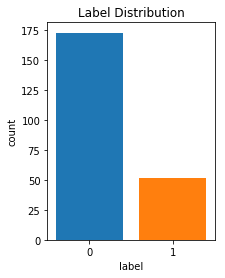

In [62]:
# 画图
plt.rcParams['figure.figsize'] = (3,4)
sns.barplot(x='label', y='count', data=label_pd, saturation=1);
plt.title('Label Distribution')
plt.savefig('label')

## 探索性数据分析
主要分析数据之间的相关性

In [59]:
df_user_pd = df_user.toPandas()

### 数据相关性


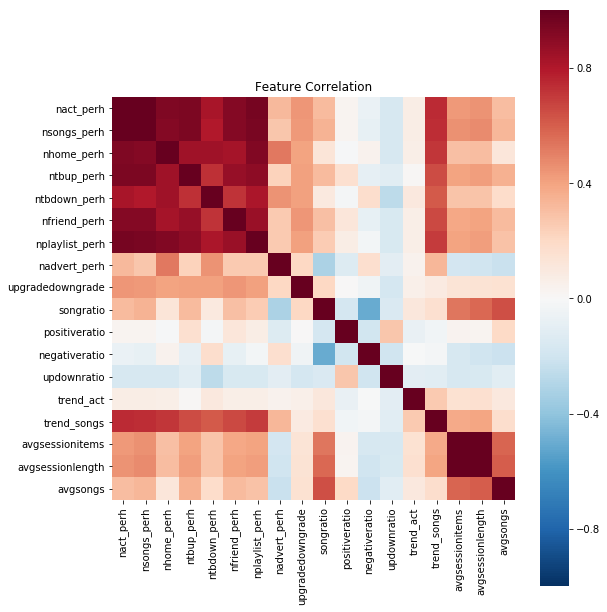

In [60]:
heatmap = df_user_pd[['nact_perh','nsongs_perh','nhome_perh','ntbup_perh','ntbdown_perh',
                      'nfriend_perh','nplaylist_perh','nadvert_perh','upgradedowngrade',
                      'songratio','positiveratio','negativeratio','updownratio','trend_act','trend_songs',
                     'avgsessionitems','avgsessionlength','avgsongs']].corr()
plt.rcParams['figure.figsize'] = (10,10)
plt.subplots_adjust(left=0.20,right=0.9,top=0.95,bottom=0.15)
sns.heatmap(heatmap, cmap="RdBu_r", square=True,vmin=-1,vmax=1);
plt.title('Feature Correlation');
plt.savefig('heatmap')

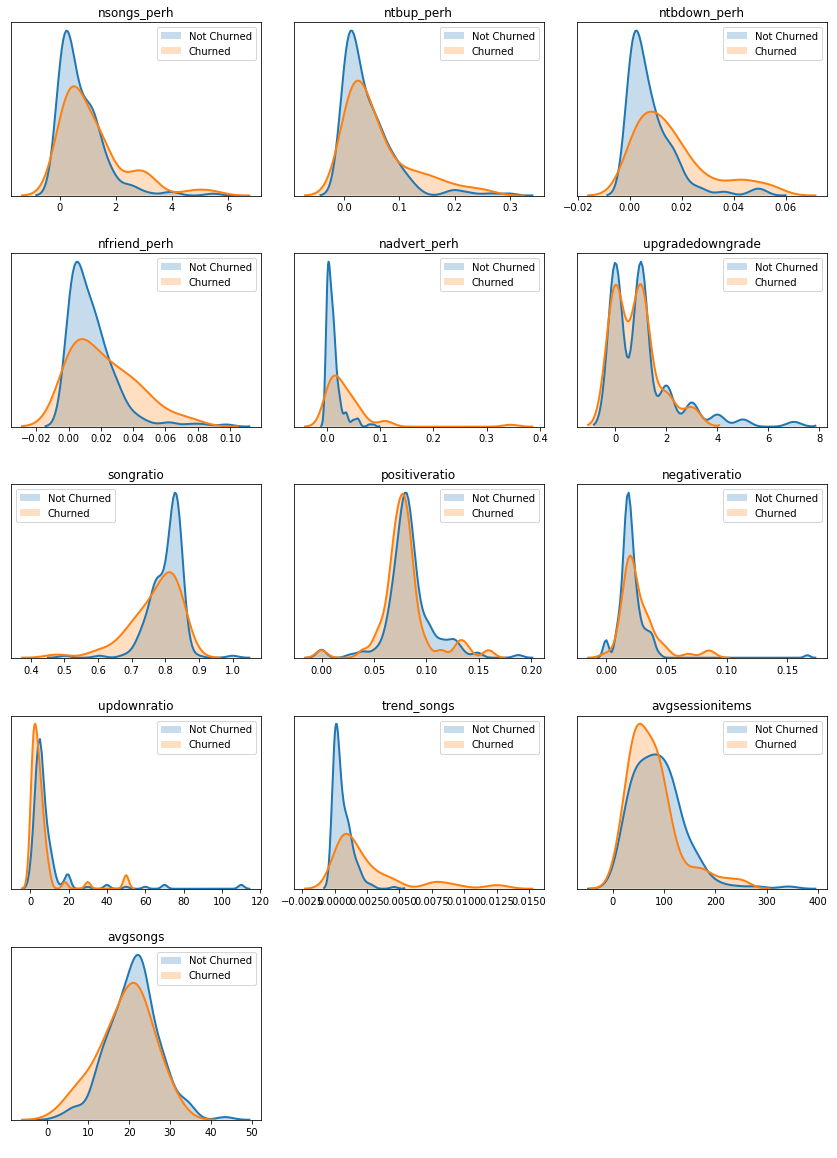

In [61]:
# 各个变量和label的相关性
col = ['nsongs_perh', 'ntbup_perh', 'ntbdown_perh',
      'nfriend_perh', 'nadvert_perh',
      'upgradedowngrade', 'songratio', 'positiveratio',
      'negativeratio', 'updownratio','trend_songs',
      'avgsessionitems', 'avgsongs']

plt.rcParams['figure.figsize'] = (12,16)
for i in range(len(col)):
    plt.subplot(5,3,i+1)
    plt.tight_layout();
    sns.distplot(df_user_pd[df_user_pd['label']==0][col[i]], hist=False, norm_hist=True,
                kde_kws = {'shade':True, 'linewidth':2});
    sns.distplot(df_user_pd[df_user_pd['label']==1][col[i]], hist=False, norm_hist=True,
                kde_kws = {'shade':True, 'linewidth':2});
    plt.legend(['Not Churned', 'Churned'])
    plt.title(col[i]);
    plt.xlabel(" ");
    plt.yticks([]);
plt.savefig('relation')

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

目前有14个数值feature，2个binary feature。

## 建立Pipeline

In [136]:
numeric_columns = ['nsongs_perh', 'ntbup_perh', 'ntbdown_perh','nfriend_perh',
                  'nadvert_perh','upgradedowngrade','songratio','positiveratio',
                   'negativeratio','updownratio','trend_songs','avgsessionitems','avgsongs']

numeric_assembler = VectorAssembler(inputCols = numeric_columns, outputCol='numericvectorized')

scaler = StandardScaler(inputCol='numericvectorized', outputCol='numericscaled',withStd=True,withMean=True)

binary_columns = ['lastlevel','gender']
total_assembler = VectorAssembler(inputCols=binary_columns + ['numericscaled'], outputCol='features')

lr = LogisticRegression()
pipeline_lr = Pipeline(stages=[numeric_assembler, scaler, total_assembler, lr])

rf = RandomForestClassifier()
pipeline_rf = Pipeline(stages=[numeric_assembler, scaler, total_assembler, rf])

gb = GBTClassifier()
pipeline_gb = Pipeline(stages=[numeric_assembler, scaler, total_assembler,gb])

## Grid Search
设置grid search的参数
a) Logistic Regression
* maxIter: 10, 30
* regParam: 0.0, 0.1
* elasticNetParam: 0.0, 0.5

b) Ramdom Forest Classifier
* maxDepth: 4,5,6,7
* numTrees: 20,40

c) Gradient-Boosted Tree Classifier
* maxDepth: 4,5
* maxIter: 20,100

使用AUC来评估，并且4-fold cross validation。

In [137]:
# Logistic regression
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.maxIter, [10,30])\
    .addGrid(lr.regParam, [0.0,0.1])\
    .addGrid(lr.elasticNetParam, [0.0,0.5])\
    .build()

crossval_lr = CrossValidator(estimator = pipeline_lr,
                            estimatorParamMaps = paramGrid_lr,
                            evaluator = BinaryClassificationEvaluator(),
                            numFolds=4)

In [138]:
# Random forest classifier
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [4,5,6,7])\
    .addGrid(rf.numTrees, [20,40])\
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                            estimatorParamMaps=paramGrid_rf,
                            evaluator = BinaryClassificationEvaluator(),
                            numFolds=4)

In [139]:
# Gradient-boosted tree classifier 
paramGrid_gb = ParamGridBuilder() \
.addGrid(gb.maxDepth, [4, 5]) \
.addGrid(gb.maxIter, [20, 100]) \
.build()

# Grid search with cross validation
crossval_gb = CrossValidator(estimator = pipeline_gb,
                          estimatorParamMaps = paramGrid_gb,
                          evaluator = BinaryClassificationEvaluator(),
                          #evaluator = F1score(),
                          numFolds = 4)

## 分割训练集和测试集

In [140]:
train_plus_val, test = df_user.randomSplit([0.8,0.2], seed=9)
ntotal = df_user.count()
ntrainval = train_plus_val.count()
ntest = test.count()

In [141]:
print(f'Original dataset: {ntotal} rows. Training and validation: {ntrainval} rows. Testing set: {ntest} rows')

Original dataset: 225 rows. Training and validation: 179 rows. Testing set: 46 rows


## 模型训练和验证

### Logistic regression

In [142]:
### logistic regression
start = time.time()
crossvalmodel_lr = crossval_lr.fit(train_plus_val)
end = time.time()

In [143]:
print(f'Time spent for grid search: {end-start} seconds')

Time spent for grid search: 1974.3633468151093 seconds


In [144]:
## store the result 
scores = crossvalmodel_lr.avgMetrics
params = [{p.name: v for p,v in m.items()} for m in crossvalmodel_lr.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['AUC score'] = scores
params_pd

,elasticNetParam,maxIter,regParam,AUC score
0,0.0,10,0.0,0.894352
1,0.5,10,0.0,0.894352
2,0.0,10,0.1,0.850100
3,0.5,10,0.1,0.852719
4,0.0,30,0.0,0.880688
5,0.5,30,0.0,0.880688
6,0.0,30,0.1,0.849238
7,0.5,30,0.1,0.851677


In [130]:
# 使用表现最好的参数训练
best_lr = LogisticRegression(maxIter = 10, regParam=0.0)
pipeline_best_lr = Pipeline(stages=[numeric_assembler, scaler, total_assembler, best_lr])

start = time.time()
model_lr = pipeline_best_lr.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {(end-start)} seconds')

Time spent for training: 143.7246778011322 seconds


In [131]:
# 在测试集上的表现
results_lr = model_lr.transform(test)
results_lr.select(['userId', 'label', 'rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   138|    0|[3.17172637279616...|[0.95975631717236...|       0.0|
|   112|    0|[1.20382927179049...|[0.76920528909787...|       0.0|
|200010|    0|[2.04833227125861...|[0.88577899551455...|       0.0|
|    34|    0|[1.86632273792383...|[0.86603221394237...|       0.0|
|     8|    0|[1.47335193124942...|[0.81356632853335...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [132]:
class F1score(Evaluator):

    def __init__(self, predictionCol = "prediction", labelCol="label"):
        self.predictionCol = predictionCol
        self.labelCol = labelCol

    def _evaluate(self, dataset):
        
        # Calculate F1 score 
        tp = dataset.where((dataset.label == 1) & (dataset.prediction == 1)).count()
        fp = dataset.where((dataset.label == 0) & (dataset.prediction == 1)).count()
        tn = dataset.where((dataset.label == 0) & (dataset.prediction == 0)).count()
        fn = dataset.where((dataset.label == 1) & (dataset.prediction == 0)).count()
        
        # Add epsilon to prevent division by zero
        precision = tp / (tp + fp + 0.00001)
        recall = tp / (tp + fn + 0.00001)
        
        f1 = 2 * precision * recall / (precision + recall + 0.00001)
        
        return f1

    def isLargerBetter(self):
        return True

In [133]:
# 在测试集上的AUC分数
auc_evaluator = BinaryClassificationEvaluator()
auc_lr = auc_evaluator.evaluate(results_lr)
print(f'Logistic regression AUC score: {auc_lr}')

Logistic regression AUC score: 0.8321678321678323


In [134]:
# 在测试集上的f1 score
f1_evaluator = F1score()
f1score_lr = f1_evaluator._evaluate(results_lr)
print(f'Logistic regression F1 score: {f1score_lr}')

Logistic regression F1 score: 0.6666613152261771


### Random forests

In [136]:
# grid search
start = time.time()
crossvalmodel_rf = crossval_rf.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {(end-start)} seconds')

Time spent for grid search: 1826.1542420387268 seconds


In [139]:
# 将分数进行保存
scores = crossvalmodel_rf.avgMetrics
params = [{p.name: v for p,v in m.items()} for m in crossvalmodel_rf.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,numTrees,score
0,4,20,0.834322
1,4,40,0.796348
2,5,20,0.831505
3,5,40,0.805858
4,6,20,0.832491
5,6,40,0.823859
6,7,20,0.839171
7,7,40,0.825622


In [144]:
# 使用表现最好的参数进行训练
best_rf = RandomForestClassifier(maxDepth=4, numTrees=40)
pipeline_best_rf = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_rf])

start = time.time()
model_rf = pipeline_best_rf.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {(end-start)} seconds')

Time spent for training: 165.51012682914734 seconds


In [148]:
# 看一下这些feature的重要性
importances = model_rf.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns


In [149]:
pd.DataFrame({"feature": names, "importance":importances_list}).sort_values('importance', ascending=False)

,feature,importance
12,trend_songs,0.303925
6,nadvert_perh,0.116693
8,songratio,0.115393
2,nsongs_perh,0.076271
11,updownratio,0.064454
14,avgsongs,0.056776
4,ntbdown_perh,0.050800
5,nfriend_perh,0.042414
7,upgradedowngrade,0.039485
13,avgsessionitems,0.036887


In [150]:
# 测试集的预测结果
results_rf = model_rf.transform(test)
results_rf.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   138|    0|[34.1426404038817...|[0.85356601009704...|       0.0|
|   112|    0|[32.156950926643,...|[0.80392377316607...|       0.0|
|200010|    0|[30.4270604882179...|[0.76067651220544...|       0.0|
|    34|    0|[33.4064196090523...|[0.83516049022630...|       0.0|
|     8|    0|[35.5077657544297...|[0.88769414386074...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [151]:
# 测试集的AUC分数
auc_evaluator = BinaryClassificationEvaluator()
auc_rf = auc_evaluator.evaluate(results_rf)
print(f'Random forest classifier AUC score: {auc_rf}')

Random forest classifier AUC score: 0.9137529137529139


In [152]:
# 测试集的f1 score
f1_evaluator = F1score()
f1score_rf = f1_evaluator._evaluate(results_rf)
print(f'Random forest classifier F1 score: {f1score_rf}')

Random forest classifier F1 score: 0.6666613152261771


### Gradient-boosted tree

In [155]:
start = time.time()
crossvalmodel_gb = crossval_gb.fit(train_plus_val)
end = time.time()
print(f'Time spent for grid search: {(end-start)}')

Time spent for grid search: 28612.447187900543


In [156]:
# 将分数保存起来
scores = crossvalmodel_gb.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in crossvalmodel_gb.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

,maxDepth,maxIter,score
0,4,20,0.846694
1,4,100,0.868529
2,5,20,0.829257
3,5,100,0.842737


In [162]:
# 使用表现最好的参数进行训练
best_gb =  GBTClassifier(maxDepth = 4, maxIter = 100)
pipeline_best_gb = Pipeline(stages = [numeric_assembler, scaler, total_assembler, best_gb])

start = time.time()
model_gb = pipeline_best_gb.fit(train_plus_val)
end = time.time()
print(f'Time spent for training: {(end-start)} seconds')

Time spent for training: 2203.7798421382904 seconds


In [163]:
# 各个feature的importance
importances = model_gb.stages[-1].featureImportances
importances_list = [importances[i] for i in range(len(importances))]
names = binary_columns + numeric_columns
pd.DataFrame({"feature": names,"importance": importances_list, }).sort_values('importance', ascending = False)

,feature,importance
12,trend_songs,0.243301
8,songratio,0.123965
2,nsongs_perh,0.111907
6,nadvert_perh,0.099789
5,nfriend_perh,0.071654
3,ntbup_perh,0.069488
11,updownratio,0.063591
10,negativeratio,0.043828
13,avgsessionitems,0.043600
4,ntbdown_perh,0.040093


In [164]:
# 测试集上的结果
results_gb = model_gb.transform(test)
results_gb.select(['userId','label','rawPrediction','probability','prediction']).show(5)

+------+-----+--------------------+--------------------+----------+
|userId|label|       rawPrediction|         probability|prediction|
+------+-----+--------------------+--------------------+----------+
|   138|    0|[1.86709408963622...|[0.97666497383235...|       0.0|
|   112|    0|[2.01360720214417...|[0.98248821738080...|       0.0|
|200010|    0|[1.37691092169654...|[0.94012883064259...|       0.0|
|    34|    0|[1.75839454466810...|[0.97116171317234...|       0.0|
|     8|    0|[2.22596072378619...|[0.98847815161789...|       0.0|
+------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [165]:
# 测试集上的AUC分数
auc_evaluator = BinaryClassificationEvaluator()
auc_gb = auc_evaluator.evaluate(results_gb)
print(f'Gradient-boosted tree classifier AUC score: {auc_gb}')

Gradient-boosted tree classifier AUC score: 0.846153846153846


In [166]:
# 测试集上的f1 score
f1_evaluator = F1score()
f1score_gb = f1_evaluator._evaluate(results_gb)
print(f'Gradient-boosted tree classifier F1 score: {f1score_gb}')

Gradient-boosted tree classifier F1 score: 0.7272672314373989


## 对三种方法进行总结
|  类型    | Logistic regression| Random Forest     | Gradient-boosted tree     |
| ---- | ---- | ---- | ---- |
| AUC     |  0.832    | 0.914     | 0.846     |
| F1 score     |  0.667    | 0.667     | 0.727     |


Random Forest具有最高的AUC得分。Gradient-boosted tree具有最高的F1 score。

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。